<a href="https://colab.research.google.com/github/Ribesh/FastAI/blob/main/Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

metrics = print out something

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
#pip install fastai --upgrade

     |████████████████████████████████| 194kB 18.5MB/s 
     |████████████████████████████████| 12.8MB 246kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
from fastai import *
from fastai.vision.all import *
import matplotlib.pyplot as plt

In [2]:
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=<function file_extract at 0x7feb58030050>, timeout=4)
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz or unzip to folder `dest`.



In [3]:
path =untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [4]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [30]:
path_anno = path/'annotations'
path_img = path/'images'
print(path_img)
print(path_anno)

/root/.fastai/data/oxford-iiit-pet/images
/root/.fastai/data/oxford-iiit-pet/annotations


In [28]:
fnames = get_image_files(path_img)
fnames[:5]

(#5) [Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_131.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Bombay_4.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_43.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_57.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_80.jpg')]

The Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 different breeds. Each image is labeled using its filename: for instance the file great_pyrenees_173.jpg is the 173rd example of an image of a Great Pyrenees breed dog in the dataset. **The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise**. **We have to tell fastai how to get labels from the filenames, which we do by calling from_name_func** (which means that labels can be extracted using a function applied to the filename), **and passing is_cat, which returns x[0].isupper(), which evaluates to True if the first letter is uppercase (i.e., it's a cat)**.

In [8]:
def is_cat(x):
  return x[0].isupper()

dls = ImageDataLoaders.from_name_func(path_img,fnames,valid_pct=0.2,seed=42,label_func=is_cat,item_tfms=Resize(224))

learn = cnn_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.172334,0.160707,0.053451,00:50


epoch,train_loss,valid_loss,error_rate,time
0,0.069056,0.278473,0.064953,00:48


The most important parameter to mention here is **valid_pct=0.2**. This tells fastai to** hold out 20% of the data and not use it for training the model at all**. This **20% of the data is called the validation set**; the remaining **80% is called the training set**. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. 

The parameter **seed=42** sets the random seed to the same value every time we run this code, which means **we get the same validation set every time we run** it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

Finally, **we define the Transforms that we need**. A Transform contains code that is applied automatically during training; fastai includes many predefined Transforms, and adding new ones is as simple as creating a Python function. **There are two kinds**: **item_tfms** are applied to each item (in this case, each item is resized to a 224-pixel square), while **batch_tfms** are applied to a batch of items at a time using the GPU, so they're particularly fast (we'll see many examples of these throughout this book)


***Learner ***

---




cnn_learner also has a parameter **pretrained, which defaults to True** (so it's used in this case, even though we haven't specified it), which **sets the weights in your model to values that have already been trained by experts** to recognize a thousand different categories across 1.3 million photos.
A model that has weights that have already been trained on some other dataset is called a **pretrained model**. You should nearly always use a pretrained model, because it means that your model, before you've even shown it any of your data, is already very capable.

**learn.fine_tune(1)**   

---


This is the key to deep learning—determining how to fit the parameters of a model to get it to solve your problem. In order to fit a model, we have to provide at **least one piece of information: how many times to look at each image** (***known as number of epochs***). The number of epochs you select will largely depend on how much time you have available, and how long you find it takes in practice to fit your model. If you select a number that is too small, you can always train for more epochs later.


But why is the method called **fine_tune**, and not **fit**? ***fastai actually does have a method called fit, which does indeed fit a model*** (i.e. look at images in the training set multiple times, each time updating the parameters to make the predictions closer and closer to the target labels). B**ut in this case, we've started with a pretrained model, and we don't want to throw away all those capabilities that it already has**.

When you use the fine_tune method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.
Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).
The head of a model is the part that is newly added to be specific to the new dataset. An epoch is one complete pass through the dataset. After calling fit, the results after each epoch are printed, showing the epoch number, the training and validation set losses (the "measure of performance" used for training the model), and any metrics you've requested (error rate, in this case).



In [ ]:
help(ImageDataLoaders)

In [10]:
interp = ClassificationInterpretation.from_learner(learn)

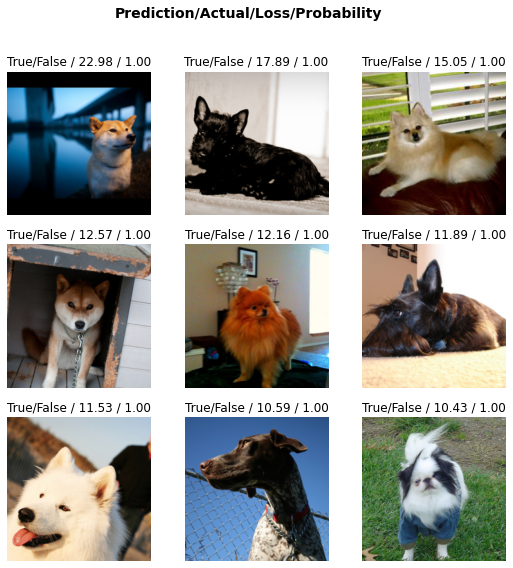

In [12]:
interp.plot_top_losses(9)

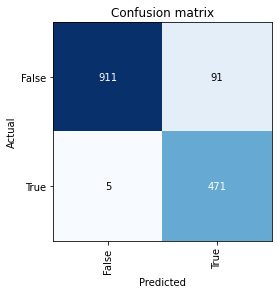

In [13]:
interp.plot_confusion_matrix()

In [24]:
import ipywidgets as widgets
uploader = widgets.FileUpload()
uploader


FileUpload(value={}, description='Upload')

In [25]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000
